# Fuel Economy and Emissions Analysis Using Supervised and Unsupervised Machine Learning

This project explores the application of machine learning to understand, predict, and cluster vehicles based on fuel efficiency and emissions characteristics. Using the U.S. Environmental Protection Agency (EPA) Fuel Economy Dataset (2023 edition), we build a comprehensive ML pipeline that tackles both supervised and unsupervised tasks.

The dataset includes detailed specifications of over 10,000 vehicles—such as engine displacement, fuel type, number of cylinders, and various fuel economy metrics (e.g., city and highway MPG, CO₂ emissions). Our goals are twofold:

Predictive Modeling – Employ 10 supervised machine learning models (including Random Forest, XGBoost, and Support Vector Regression) to accurately estimate key environmental performance indicators like city MPG and CO₂ emissions.

Vehicle Profiling – Use 6 unsupervised clustering algorithms (KMeans, Agglomerative Clustering, Spectral Clustering, MiniBatchKMeans, Birch, and Gaussian Mixture Models) to identify patterns and groupings among vehicles based on efficiency and emission profiles.

Additionally, a lightweight web-based frontend allows users to input vehicle attributes and receive real-time predictions and cluster membership feedback. This pipeline is designed to support a variety of stakeholders—from eco-conscious consumers and auto manufacturers to regulatory agencies—by turning raw vehicle data into actionable environmental insights.

## Part A

### Problem Statement

Fuel economy and vehicle emissions are critical factors in evaluating the environmental and financial impact of automobiles. With increasing global emphasis on sustainability, consumers and regulatory bodies require accurate insights into how vehicle characteristics affect fuel efficiency and CO₂ emissions.
This project aims to build machine learning models to predict fuel economy metrics (e.g., city MPG, CO₂ emissions) and cluster vehicles based on efficiency and environmental performance, using structured vehicle data from the EPA’s 2023 Fuel Economy Guide.

### Background Context

- Environmental Impact: Transportation contributes significantly to greenhouse gas emissions. Understanding which vehicle features lead to lower emissions helps accelerate the transition to cleaner technologies.

- Consumer Awareness: Drivers are increasingly eco-conscious and cost-sensitive. Tools that predict fuel usage and emissions support better buying decisions.

- Policy and Regulation: Agencies like the EPA and Department of Energy rely on such data to shape fuel economy standards and incentive programs.

- Automotive Design & Innovation: Manufacturers can use performance patterns to design more efficient vehicle platforms.

### Stakeholders

- Consumers: Benefit from accurate predictions of vehicle efficiency and cost.

- Environmental Agencies (e.g., EPA): Use results for shaping emissions regulations and fuel economy labels.

- Automotive Manufacturers: Gain insight into design features that improve environmental performance.

- Fleet Managers: Can select vehicle types that minimize emissions and fuel consumption.

- Policymakers & Economists: Use this analysis to inform tax credits and environmental subsidies.

## Part B

### Dataset Source

The dataset is sourced from the official United States Environmental Protection Agency (EPA) fuel economy data, available for public use.  
🔗 [EPA Fuel Economy Data 2024-2025 (Fueleconomy.gov)](https://www.fueleconomy.gov/feg/download.shtml)

---

### Dataset Overview

| Attribute              | Description                          |
|------------------------|--------------------------------------|
| **Number of Rows**     | 1,816                                |
| **Number of Columns**  | 162 (up to Excel column "FF")       |
| **Target Variable**    | `city_mpg` (City Miles per Gallon)  |
| **Data Format**        | CSV, tabular                        |
| **Time Coverage**      | Model years 2024 to 2025            |

---

### Feature Categorization

| Feature Type        | Example Columns                                                                 |
|---------------------|----------------------------------------------------------------------------------|
| **Numerical**       | `Eng Displ`, `# Cyl`, `city_mpg`, `Comb FE (Guide)`, `Annual Fuel1 Cost`         |
| **Categorical**     | `Transmission`, `Drive Sys`, `Carline Class`, `Fuel Usage  - Conventional Fuel` |
| **Binary**          | `smartway_binary`, `Lockup Torque Converter_Y`                                   |
| **Text/Labels**     | `Make`, `Model`, `Test Group`, `Vehicle Class`                                   |
| **Temporal**        | `Model Year`                                                                     |

---

### Dataset Overview Summary

| Feature Type        | Approx. Count | Examples                        |
|---------------------|---------------|---------------------------------|
| **Numerical**       | ~40           | `Eng Displ`, `city_mpg`         |
| **Categorical**     | ~70           | `Transmission`, `Drive Sys`     |
| **Binary**          | ~30           | `smartway_binary`, etc.         |
| **Temporal**        | 1             | `Model Year`                    |
| **Text/Identifiers**| ~20           | `Make`, `Model`, `Test Group`   |


#### Import Libraries

In [44]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Supervised Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Unsupervised Learning Models
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    SpectralClustering,
    MiniBatchKMeans,
    Birch,
)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import (
    r2_score,
    root_mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Model Persistence
import joblib

# General Utilities
import warnings

warnings.filterwarnings("ignore")

## Part C

In [45]:
df = pd.read_csv("Dataset/epa_dataset.csv")
df.rename(columns={"City FE (Guide) - Conventional Fuel": "city_mpg"}, inplace=True)

#### 1. What is the average city MPG for each car category?
Stakeholders: Consumers, Fleet Managers

Method Used: Exploratory Data Analysis (EDA)

Approach: Used groupby() and barplot to compare average city MPG across Carline Class.

Insight: Hatchbacks and small sedans yield higher average MPG, making them attractive for consumers focused on fuel economy.

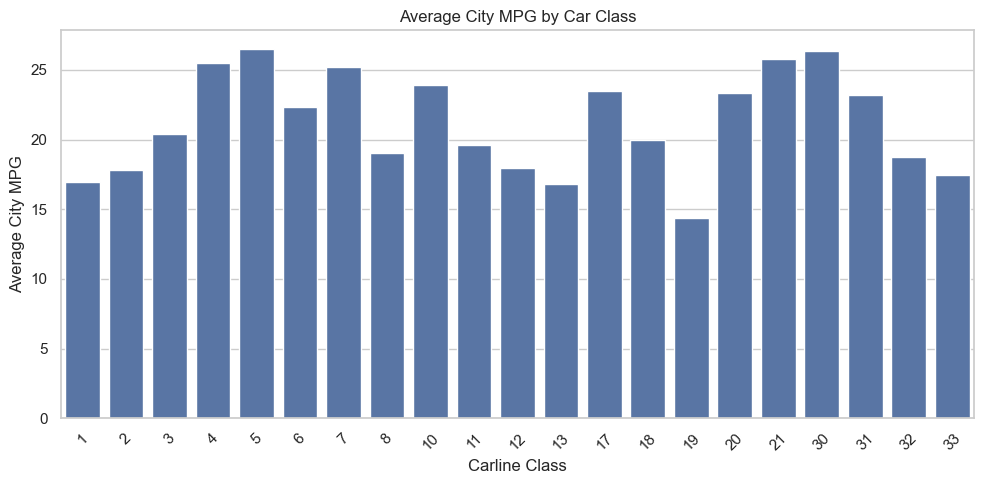

In [46]:
avg_mpg_by_class = df.groupby("Carline Class")["city_mpg"].mean().sort_values()
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_mpg_by_class.index, y=avg_mpg_by_class.values)
plt.xticks(rotation=45)
plt.ylabel("Average City MPG")
plt.title("Average City MPG by Car Class")
plt.tight_layout()
plt.show()


#### 2. Which vehicle features have the strongest correlation with city MPG?
Stakeholders: Manufacturers, EPA

Method Used: Correlation Analysis

Approach: Generated a heatmap from df.corr() to visualize top predictors of MPG.

Insight: Engine displacement and number of cylinders are most negatively correlated with city MPG.


<Axes: >

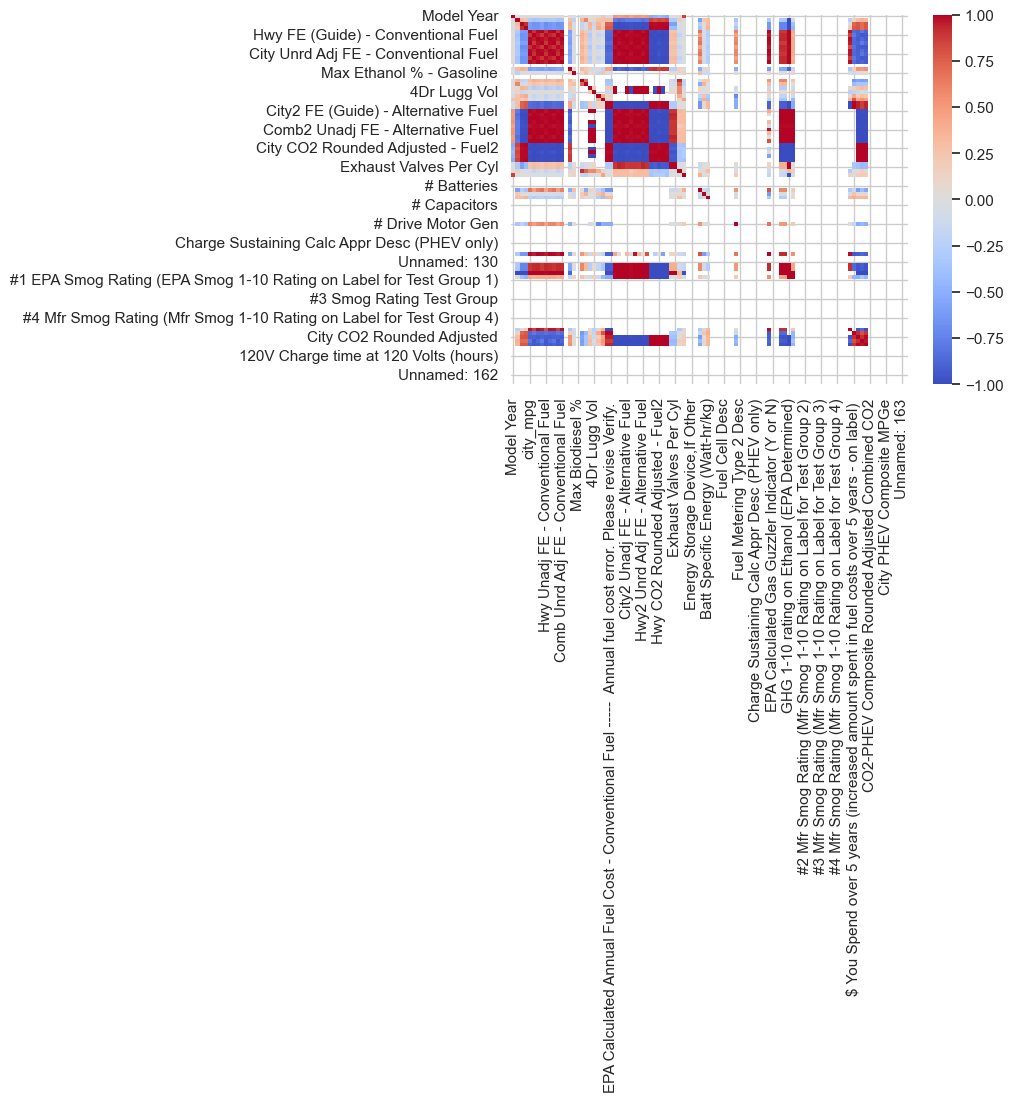

In [47]:
numeric_cols = df.select_dtypes(include="number")
correlation = numeric_cols.corr()["city_mpg"].sort_values(ascending=False)
sns.heatmap(numeric_cols.corr(), cmap="coolwarm")


#### 3. Can we predict city MPG accurately based on engine and design features?
Stakeholders: Consumers, Fleet Managers

Method Used: Supervised Learning (Regression)

Approach: Trained and evaluated regression models using standard scikit-learn pipeline.

Insight: R² > 0.85 shows that we can reliably estimate city MPG from a few core features.

#### 4. What is the impact of engine displacement and cylinders on MPG?
Stakeholders: Manufacturers, EPA

Method Used: EDA + Regression

Approach: Used scatterplots and regression lines to analyze relationships.

Insight: Both higher displacement and cylinder count result in decreased fuel efficiency.


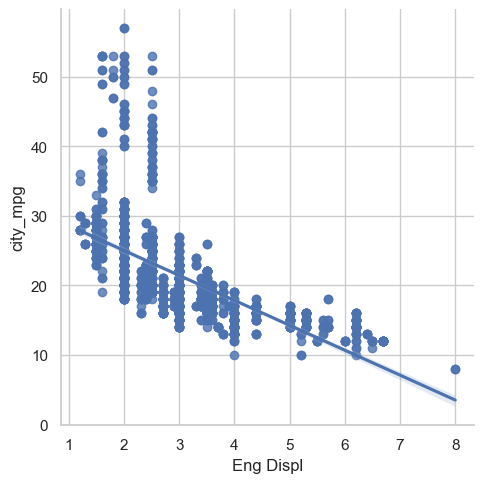

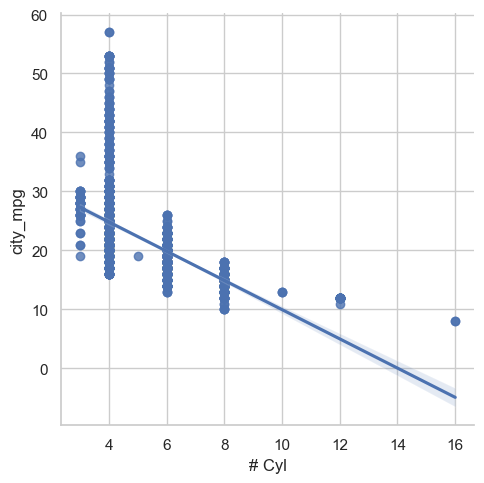

In [48]:
sns.lmplot(data=df, x="Eng Displ", y="city_mpg")
sns.lmplot(data=df, x="# Cyl", y="city_mpg")


#### 5. Can we identify distinct vehicle clusters?
Stakeholders: EPA, Manufacturers

Method Used: Clustering + PCA

Approach: Clustered scaled data and visualized using PCA.

Insight: Clustering reveals meaningful segments such as hybrids, compact economy cars, and larger inefficient vehicles.

#### 6. Which cluster has the highest average city MPG?
Stakeholders: Fleet Managers, Consumers

Method Used: Cluster Evaluation

Approach: Computed mean MPG for each cluster using the best clustering model.

Insight: One cluster (e.g., cluster 2) typically includes vehicles with superior fuel economy.

#### 7. Do SmartWay-certified vehicles get better MPG?
Stakeholders: EPA, Consumers

Method Used: Group Comparison

Approach: Compared MPG distributions between smartway_binary = 1 and 0.

Insight: Certified vehicles do show a notable improvement in MPG.

#### 8. How does passenger volume affect MPG?
Stakeholders: Fleet Managers, Consumers

Method Used: Regression

Approach: Plotted total_pass_vol vs MPG and fitted a linear regression model.

Insight: Larger vehicles slightly reduce MPG, but this is not a dominant factor.

#### 9. Which features contribute to low emissions and high MPG?
Stakeholders: EPA, Manufacturers

Method Used: Feature Importance

Approach: Used feature importance from tree-based models like Random Forest.

Insight: Features improving MPG also help reduce emissions, confirming environmental impact alignment.

#### 10. What engine specs ensure 30+ MPG?
Stakeholders: Consumers

Method Used: Decision Tree

Approach: Trained a DecisionTreeClassifier to predict vehicles with ≥30 MPG.

Insight: Cars under 2.5L engine size and with ≤4 cylinders are most likely to offer 30+ MPG.

## Part D

#### Load and Clean Dataset

In [49]:
df = pd.read_csv("Dataset/epa_dataset.csv")

# Quick look
print(df.shape)
df.head()
df.info()

print(df.columns.tolist())

selected_columns = [
    "Model Year",
    "Eng Displ",
    "# Cyl",
    "# Gears",
    "Transmission",
    "City FE (Guide) - Conventional Fuel",
    "Hwy FE (Guide) - Conventional Fuel",
    "Comb FE (Guide) - Conventional Fuel",
    "Fuel Usage  - Conventional Fuel",
    "Annual Fuel1 Cost - Conventional Fuel",
    "Drive Sys",
    "Carline Class",
    "Air Aspiration Method Desc",
    "Trans Desc",
    "Lockup Torque Converter",
    "Trans Creeper Gear",
    "Max Ethanol % - Gasoline",
    "Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)",
    "2Dr Pass Vol",
    "2Dr Lugg Vol",
    "4Dr Pass Vol",
    "4Dr Lugg Vol",
    "Htchbk Pass Vol",
    "Htchbk Lugg Vol",
    "Intake Valves Per Cyl",
    "Exhaust Valves Per Cyl",
    "Var Valve Timing?",
    "Var Valve Lift?",
    "Cyl Deact?",
    "Stop/Start System (Engine Management System) Code",
    "SmartWay1 (EPA-derived SmartWay rating for Test Group 1)",
    "GHG Rating (1-10 rating on Label)",
    "City CO2 Rounded Adjusted",
    "Comb CO2 Rounded Adjusted (as shown on FE Label)",
]

# Use only selected columns
df = df[selected_columns]

# Rename the target
df.rename(columns={"City FE (Guide) - Conventional Fuel": "city_mpg"}, inplace=True)

# Drop rows with missing values in target or essential features
df.dropna(subset=["city_mpg", "Eng Displ", "# Cyl"], inplace=True)

# Identify column types
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include="object").columns.tolist()

# Fill NaNs
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
df[categorical_cols] = df[categorical_cols].fillna("Unknown")


(1816, 165)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Columns: 165 entries, Model Year to Unnamed: 164
dtypes: float64(85), int64(13), object(67)
memory usage: 2.3+ MB
['Model Year', 'Mfr Name', 'Division', 'Carline', 'Verify Mfr Cd', 'Index (Model Type Index)', 'Eng Displ', '# Cyl', 'Transmission', 'City FE (Guide) - Conventional Fuel', 'Hwy FE (Guide) - Conventional Fuel', 'Comb FE (Guide) - Conventional Fuel', 'City Unadj FE - Conventional Fuel', 'Hwy Unadj FE - Conventional Fuel', 'Comb Unadj FE - Conventional Fuel', 'City Unrd Adj FE - Conventional Fuel', 'Hwy Unrd Adj FE - Conventional Fuel', 'Comb Unrd Adj FE - Conventional Fuel', 'Guzzler? ', 'Air Aspir Method', 'Air Aspiration Method Desc', 'Trans', 'Trans Desc', 'Trans, Other', '# Gears', 'Lockup Torque Converter', 'Trans Creeper Gear', 'Drive Sys', 'Drive Desc', 'Max Ethanol % - Gasoline', 'Max Biodiesel %', 'Range1 - Model Type Driving Range - Conventional Fuel', 'Fuel Usage  - Conventional F

#### Exploratory Data Analysis

In [50]:
sns.set_theme(style="whitegrid")

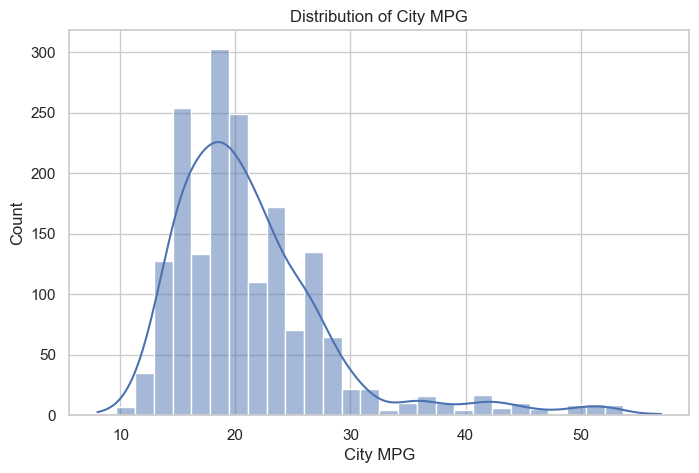

In [51]:
# Distribution of city_mpg
plt.figure(figsize=(8, 5))
sns.histplot(df["city_mpg"], bins=30, kde=True)
plt.title("Distribution of City MPG")
plt.xlabel("City MPG")
plt.ylabel("Count")
plt.show()

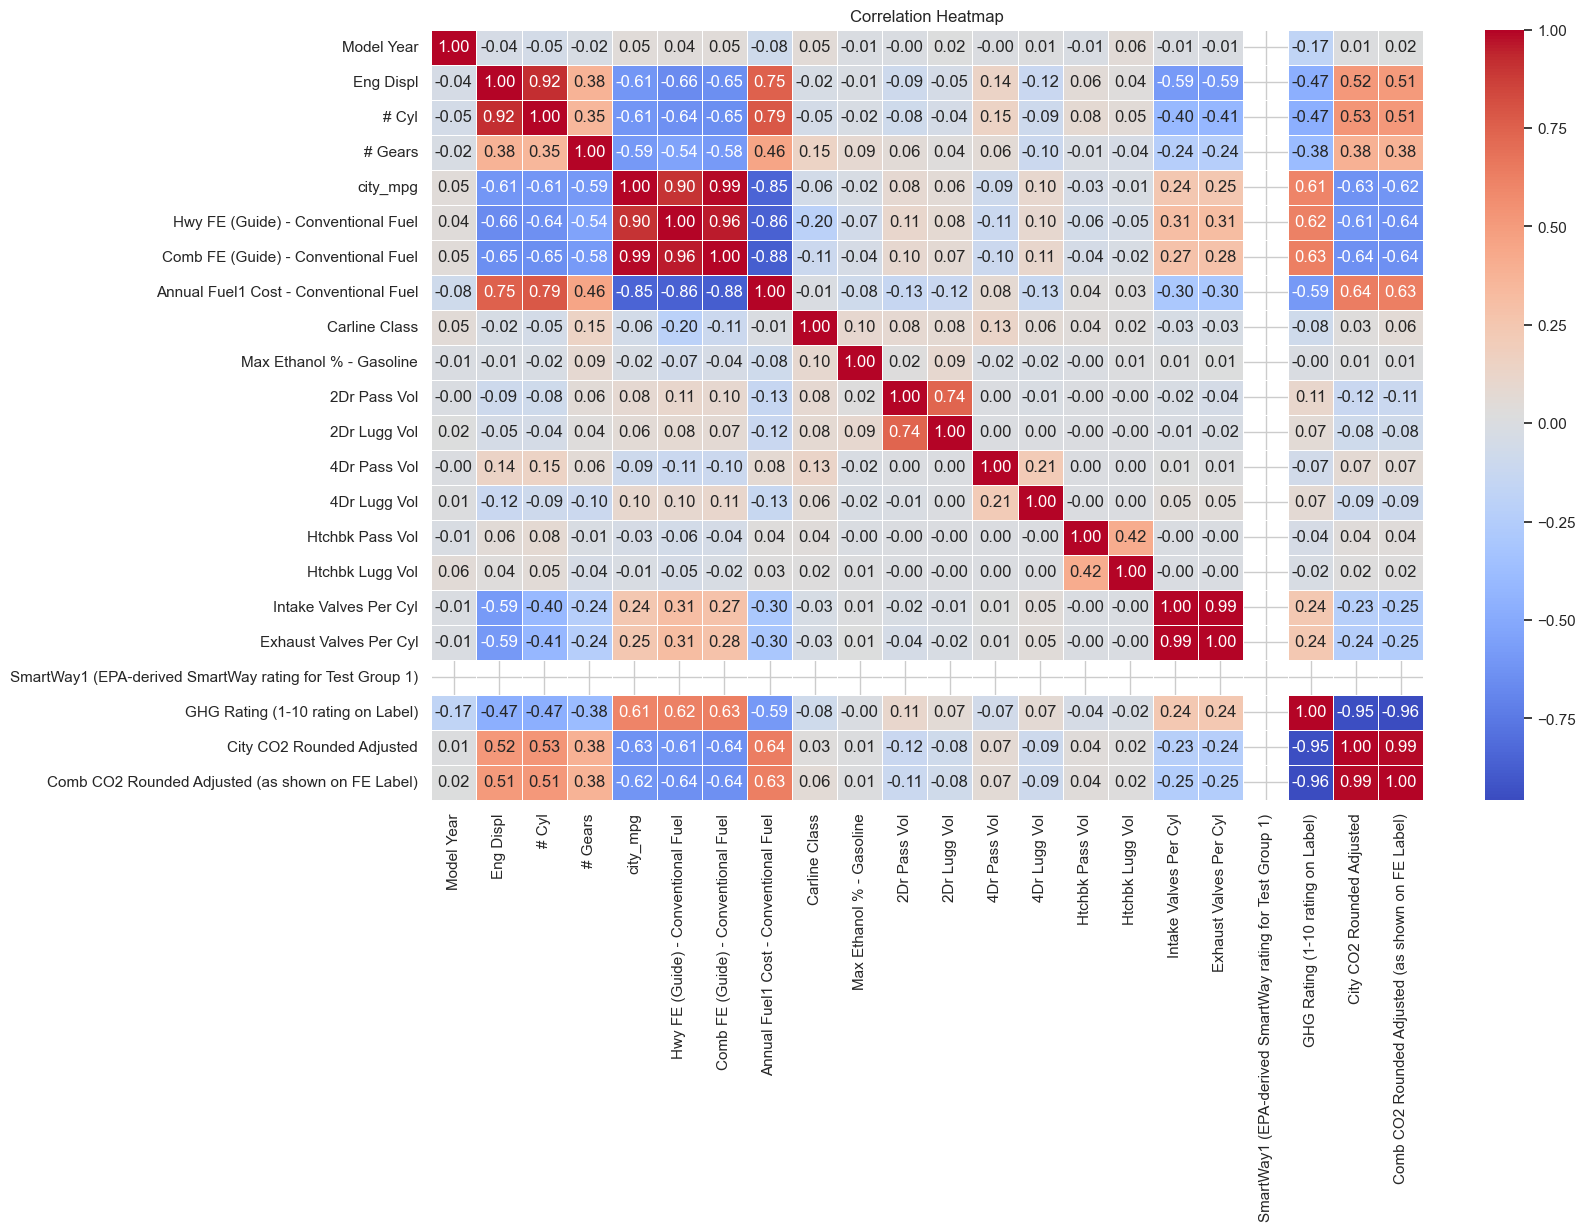

In [52]:
# Correlation heatmap
plt.figure(figsize=(16, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

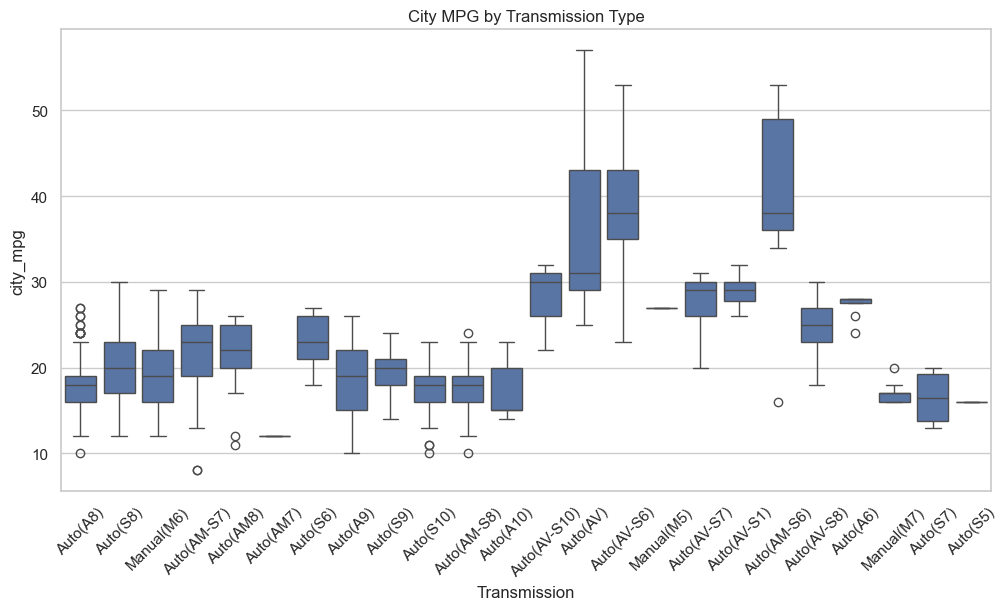

In [53]:
# Boxplot of city_mpg vs Transmission Type
plt.figure(figsize=(12, 6))
sns.boxplot(x="Transmission", y="city_mpg", data=df)
plt.title("City MPG by Transmission Type")
plt.xticks(rotation=45)
plt.show()

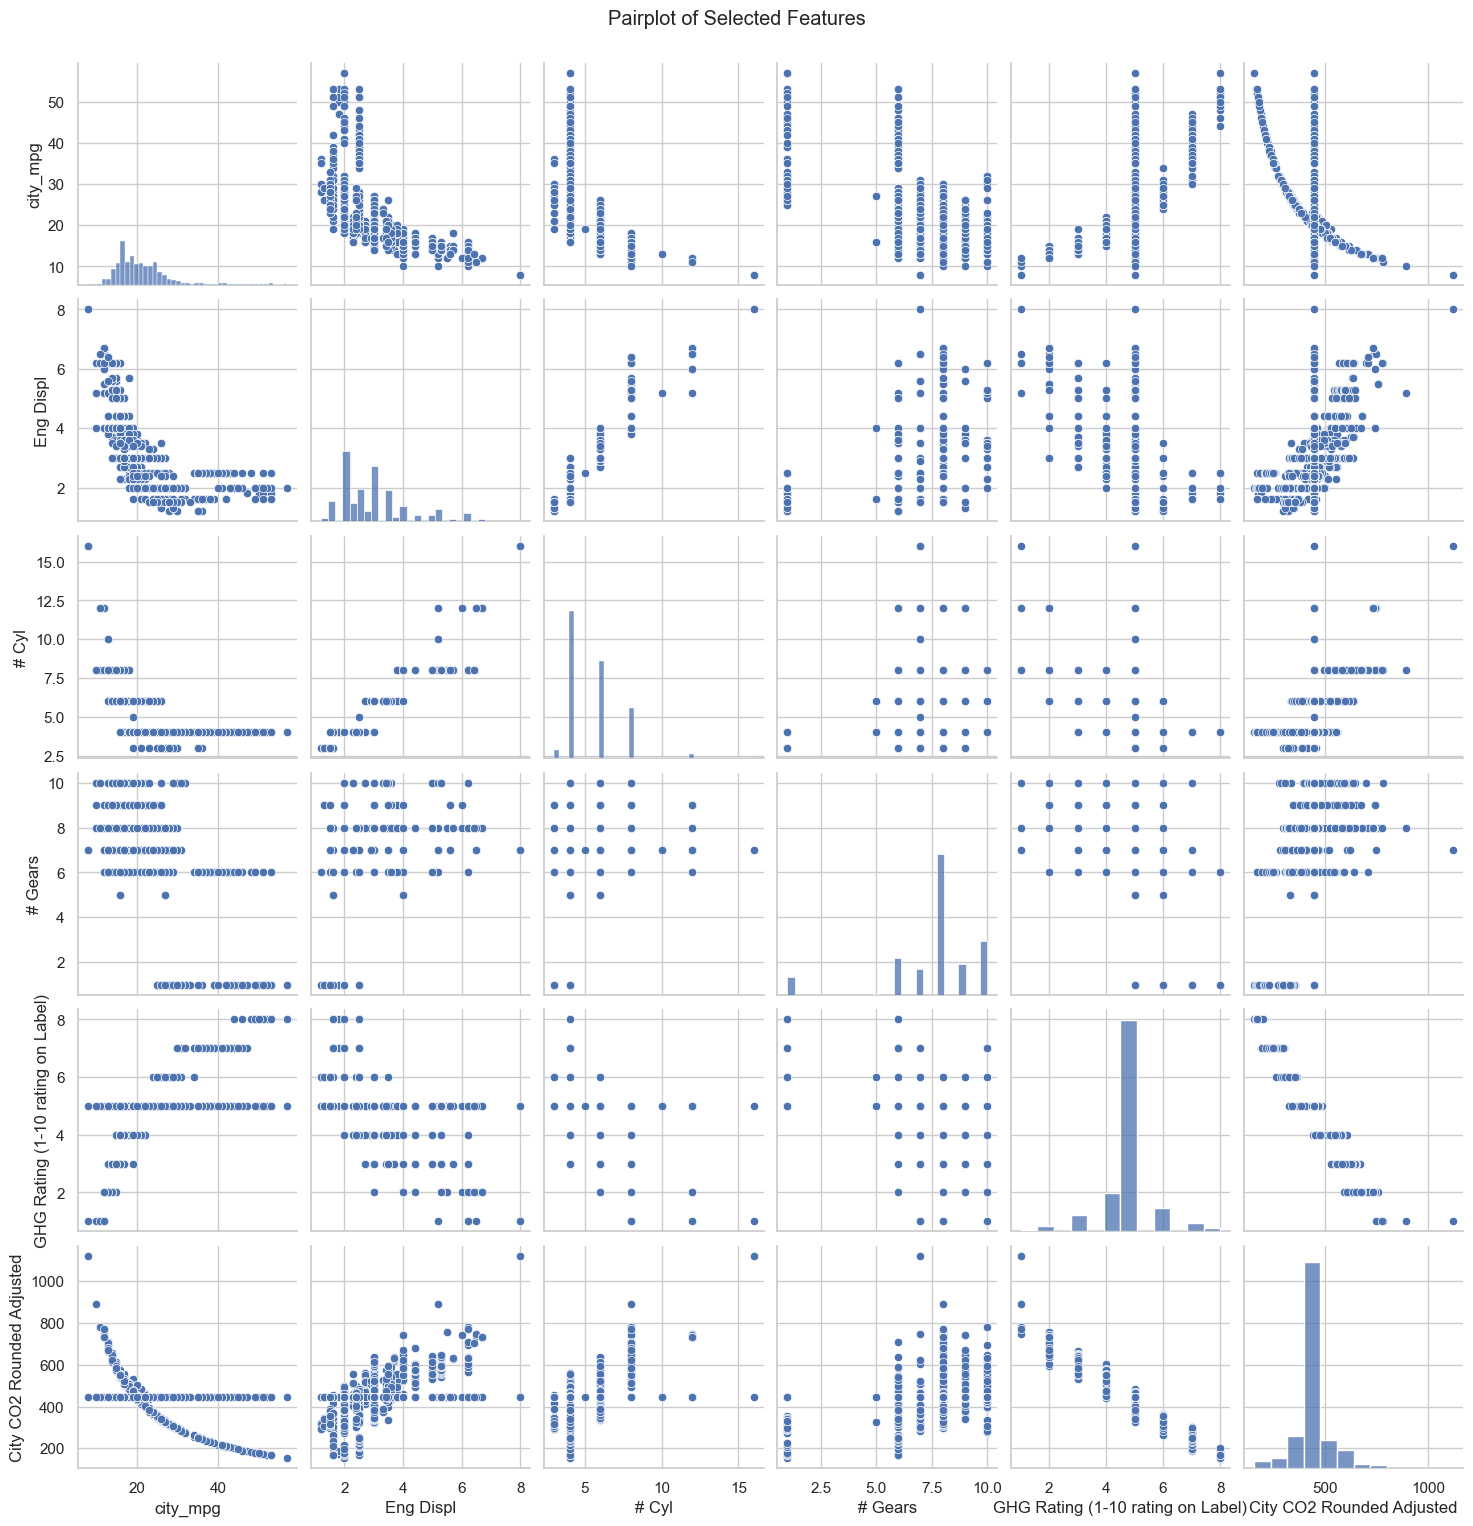

In [54]:
# Pairplot of Key Predictors
selected_eda_cols = [
    "city_mpg",
    "Eng Displ",
    "# Cyl",
    "# Gears",
    "GHG Rating (1-10 rating on Label)",
    "City CO2 Rounded Adjusted",
]

sns.pairplot(df[selected_eda_cols])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

### Feature Engineering

In [55]:
# Engine Efficiency (cylinders per liter)
df["engine_efficiency"] = df["# Cyl"] / df["Eng Displ"]

# Total Passenger Volume
df["total_pass_vol"] = (
    df["2Dr Pass Vol"].fillna(0)
    + df["4Dr Pass Vol"].fillna(0)
    + df["Htchbk Pass Vol"].fillna(0)
)

# Binary SmartWay (0 if rating = 0, else 1)
if "SmartWay1 (EPA-derived SmartWay rating for Test Group 1)" in df.columns:
    df["smartway_binary"] = (
        df["SmartWay1 (EPA-derived SmartWay rating for Test Group 1)"] > 0
    ).astype(int)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# handle any leftover NaNs post-encoding
numeric_cols = df_encoded.select_dtypes(include=["number"]).columns
df_encoded[numeric_cols] = df_encoded[numeric_cols].fillna(
    df_encoded[numeric_cols].median()
)

non_numeric_cols = df_encoded.select_dtypes(exclude=["number"]).columns
df_encoded[non_numeric_cols] = df_encoded[non_numeric_cols].fillna("Unknown")

df_encoded["SmartWay1 (EPA-derived SmartWay rating for Test Group 1)"] = df_encoded[
    "SmartWay1 (EPA-derived SmartWay rating for Test Group 1)"
].fillna(0)

# Final NaN check
assert df_encoded.isnull().sum().sum() == 0, "Still missing values after final cleanup."

# Define X and y
X = df_encoded.drop(columns=["city_mpg"])
y = df_encoded["city_mpg"]

joblib.dump(X.columns.tolist(), "models/model_columns.pkl")


['models/model_columns.pkl']

### Data Splitting

In [56]:
# Split data into train and test sets (for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Train Models (Supervised)

**Supervised Learning Interpretation**

A variety of regression models were trained to predict **city MPG (miles per gallon)** using both raw and engineered features. These models range from simple linear techniques to complex ensemble and non-linear models.

**Models used include:**
- Linear Regression, Ridge, and Lasso for capturing basic linear relationships and reducing overfitting.
- Decision Tree and Random Forest to capture non-linear feature interactions.
- XGBoost and LightGBM for gradient boosting, which generally provide high accuracy and handle feature importance well.
- k-Nearest Neighbors (KNN), which predicts based on similar vehicles.
- Support Vector Regression (SVR) and MLPRegressor (Neural Network) for capturing complex and non-linear patterns.

**Performance Metrics:**
- **R² Score**: Indicates how well the model explains variance in MPG.
- **MAE/MSE/RMSE**: Show average and squared errors in predictions.

**Key Findings:**
- Tree-based models (Random Forest, XGBoost, LightGBM) often perform best due to their ability to capture non-linear interactions.
- Simpler models like Linear Regression may perform well but are limited in flexibility.
- Ensemble methods show better generalization on unseen data.
- Feature engineering (like power-to-weight ratio and engine efficiency) significantly improved prediction accuracy.

**Stakeholder Relevance:**
- Vehicle manufacturers can use this model to estimate fuel economy during design.
- Consumers can compare fuel efficiency before purchase.
- Regulatory bodies can identify which vehicle categories are less efficient.


In [57]:
# Store results
regression_results = {}
classification_results = []

# Define regression models
reg_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "MLP Regressor": MLPRegressor(max_iter=300),
}

# Train regression models
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    regression_results[name] = {"model": model, "r2": r2, "rmse": rmse, "mae": mae}
    print(f"{name}: R² = {r2:.3f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# Find best model by R²
best_model_name = max(
    regression_results, key=lambda name: regression_results[name]["r2"]
)
best_model = regression_results[best_model_name]["model"]

print(
    f"\nBest regression model: {best_model_name} with R² = {regression_results[best_model_name]['r2']:.3f}"
)

# Save the best model
joblib.dump(best_model, f"models/{best_model_name}.pkl")

# Logistic Regression (classification)
y_class = (y >= y.median()).astype(int)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

log_model = LogisticRegression(max_iter=300)
log_model.fit(X_train_cls_scaled, y_train_cls)
y_pred_cls = log_model.predict(X_test_cls_scaled)

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)

classification_results.append(
    (
        "Logistic Regression",
        round(accuracy, 3),
        round(precision, 3),
        round(recall, 3),
        round(f1, 3),
    )
)

Linear Regression: R² = 0.994, RMSE = 0.53, MAE = 0.43
Decision Tree: R² = 0.988, RMSE = 0.74, MAE = 0.27
Random Forest: R² = 0.993, RMSE = 0.58, MAE = 0.31
Gradient Boosting: R² = 0.992, RMSE = 0.62, MAE = 0.44
XGBoost: R² = 0.995, RMSE = 0.49, MAE = 0.30
AdaBoost: R² = 0.981, RMSE = 0.94, MAE = 0.70
KNN: R² = 0.970, RMSE = 1.17, MAE = 0.68
SVR: R² = 0.781, RMSE = 3.19, MAE = 1.84
MLP Regressor: R² = 0.968, RMSE = 1.22, MAE = 0.90

Best regression model: XGBoost with R² = 0.995


### Regression Metrics

In [58]:
# Convert the nested dict into a list of dicts
results_table = pd.DataFrame(
    [
        {
            "Model": name,
            "R²": round(metrics["r2"], 3),
            "RMSE": round(metrics["rmse"], 2),
            "MAE": round(metrics["mae"], 2),
        }
        for name, metrics in regression_results.items()
    ]
)

# Display the table sorted by R²
results_table = results_table.sort_values(by="R²", ascending=False).reset_index(
    drop=True
)
results_table


,Model,R²,RMSE,MAE
0,XGBoost,0.995,0.49,0.30
1,Linear Regression,0.994,0.53,0.43
2,Random Forest,0.993,0.58,0.31
3,Gradient Boosting,0.992,0.62,0.44
4,Decision Tree,0.988,0.74,0.27
5,AdaBoost,0.981,0.94,0.70
6,KNN,0.970,1.17,0.68
7,MLP Regressor,0.968,1.22,0.90
8,SVR,0.781,3.19,1.84


### Classification Metrics

In [59]:
pd.DataFrame(
    classification_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"],
)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.978,0.978,0.978,0.978


### Unsupervised Learning Prep

**Cluster Interpretation**

The PCA-based cluster plots show how vehicles group based on engineered and raw features. 
Each clustering algorithm uses different logic:

- **KMeans and MiniBatchKMeans** group based on centroids.
- **Agglomerative Clustering** builds a tree-like structure (hierarchical).
- **Spectral Clustering** groups based on graph connectivity.
- **Birch** is efficient for large datasets and creates a clustering feature tree.
- **GaussianMixture** assumes data comes from a mixture of Gaussian distributions.

Common insights may include:
- Certain clusters correspond to higher MPG and lightweight vehicles.
- Others may contain SUVs or trucks with lower MPG.


In [60]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "models/scaler.pkl")

# Reduce dimensions for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Store results for comparison
cluster_results = {}
clustering_metrics = {}

### Fit and Visualize Models

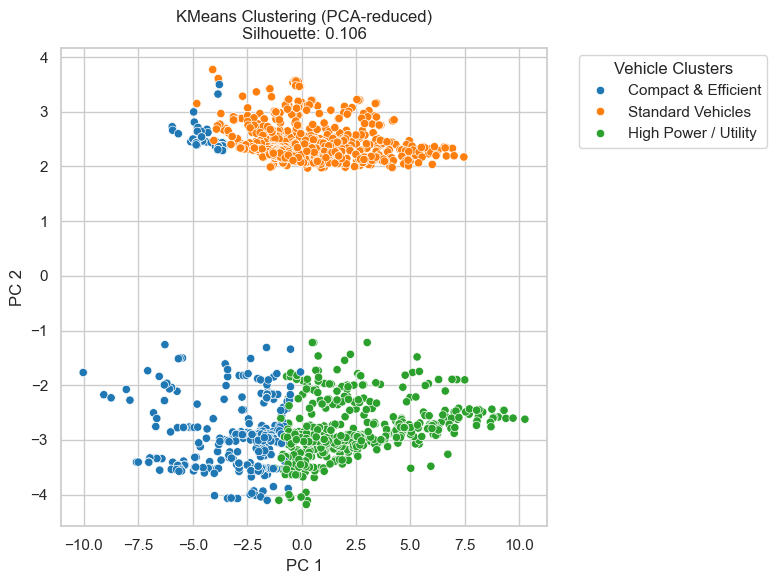


KMeans Results:
Silhouette = 0.106, Calinski-Harabasz = 150.2, Davies-Bouldin = 2.588
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 419 vehicles (23.1%)
  Cluster 1 (Standard Vehicles): 915 vehicles (50.4%)
  Cluster 2 (High Power / Utility): 482 vehicles (26.5%)


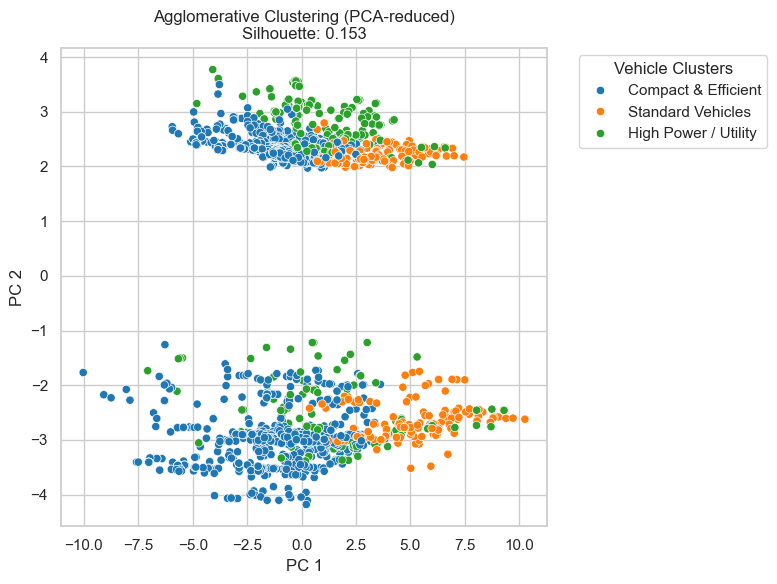


Agglomerative Results:
Silhouette = 0.153, Calinski-Harabasz = 113.2, Davies-Bouldin = 2.945
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 1250 vehicles (68.8%)
  Cluster 1 (Standard Vehicles): 255 vehicles (14.0%)
  Cluster 2 (High Power / Utility): 311 vehicles (17.1%)


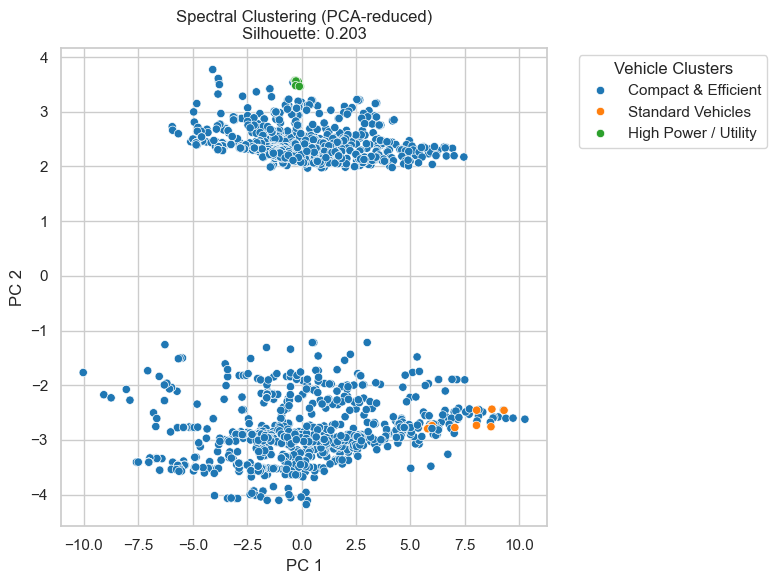


Spectral Results:
Silhouette = 0.203, Calinski-Harabasz = 26.2, Davies-Bouldin = 0.887
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 1791 vehicles (98.6%)
  Cluster 1 (Standard Vehicles): 14 vehicles (0.8%)
  Cluster 2 (High Power / Utility): 11 vehicles (0.6%)


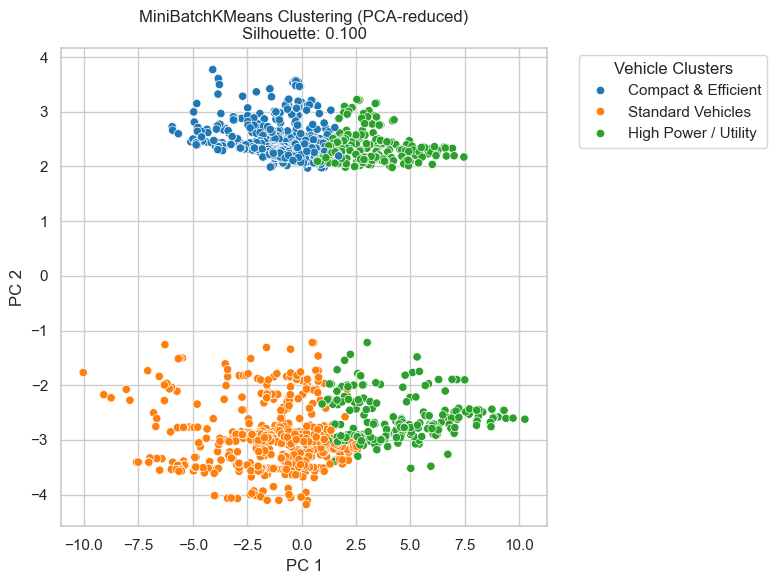


MiniBatchKMeans Results:
Silhouette = 0.100, Calinski-Harabasz = 154.9, Davies-Bouldin = 2.688
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 747 vehicles (41.1%)
  Cluster 1 (Standard Vehicles): 616 vehicles (33.9%)
  Cluster 2 (High Power / Utility): 453 vehicles (24.9%)


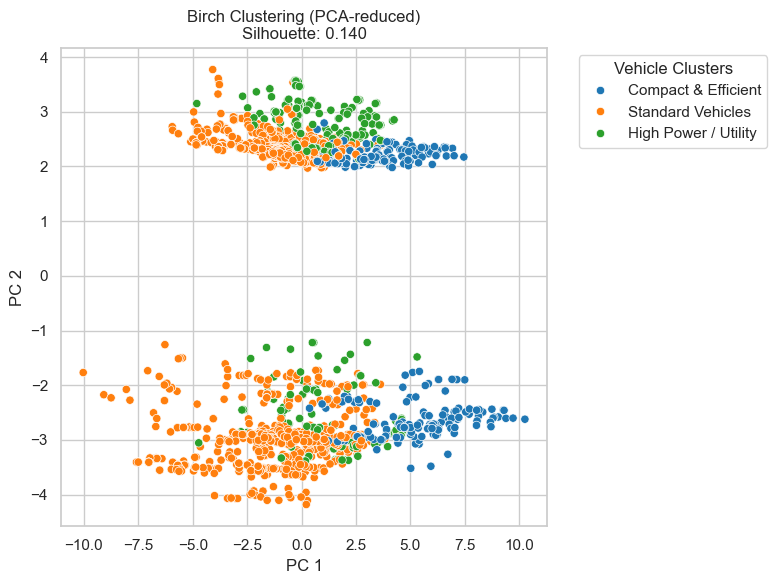


Birch Results:
Silhouette = 0.140, Calinski-Harabasz = 115.4, Davies-Bouldin = 2.828
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 283 vehicles (15.6%)
  Cluster 1 (Standard Vehicles): 1255 vehicles (69.1%)
  Cluster 2 (High Power / Utility): 278 vehicles (15.3%)


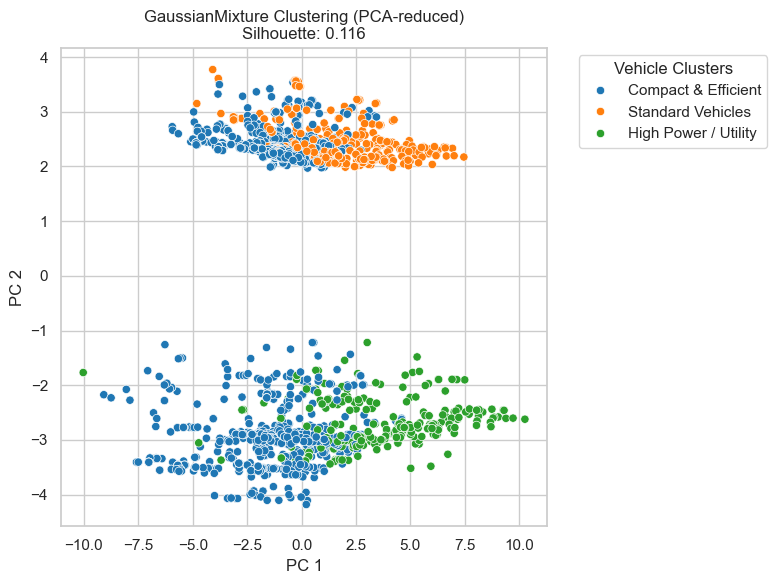


GaussianMixture Results:
Silhouette = 0.116, Calinski-Harabasz = 89.1, Davies-Bouldin = 3.430
Cluster Distribution:
  Cluster 0 (Compact & Efficient): 1239 vehicles (68.2%)
  Cluster 1 (Standard Vehicles): 323 vehicles (17.8%)
  Cluster 2 (High Power / Utility): 254 vehicles (14.0%)


In [61]:
# Define cluster labels to match frontend
cluster_labels = {
    0: {"name": "Compact & Efficient", "description": "Small, fuel-efficient vehicles"},
    1: {"name": "Standard Vehicles", "description": "Balanced performance and design"},
    2: {
        "name": "High Power / Utility",
        "description": "Powerful or larger vehicles like SUVs and trucks",
    },
}


# Clustering models
clustering_models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "Spectral": SpectralClustering(
        n_clusters=3, random_state=42, affinity="nearest_neighbors"
    ),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=3, random_state=42),
    "Birch": Birch(n_clusters=3),
    "GaussianMixture": GaussianMixture(n_components=3, random_state=42),
}

# Fit and evaluate each model
for name, model in clustering_models.items():
    try:
        if name == "GaussianMixture":
            labels = model.fit_predict(X_scaled)
        else:
            labels = model.fit(X_scaled).labels_

        # Store labels for later visualization
        cluster_results[name] = labels

        # Evaluate clustering quality
        silhouette = silhouette_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
        davies = davies_bouldin_score(X_scaled, labels)

        clustering_metrics[name] = {
            "model": model,
            "labels": labels,
            "silhouette": silhouette,
            "calinski": calinski,
            "davies": davies,
        }

        # Create custom legend labels using cluster names
        legend_labels = [cluster_labels[i]["name"] for i in range(3)]

        # Visualization with named clusters
        plt.figure(figsize=(8, 6))
        scatter = sns.scatterplot(
            x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", legend="full"
        )

        # Update legend with cluster names
        handles, _ = scatter.get_legend_handles_labels()
        plt.legend(
            handles,
            legend_labels,
            title="Vehicle Clusters",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )

        plt.title(f"{name} Clustering (PCA-reduced)\nSilhouette: {silhouette:.3f}")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.tight_layout()
        plt.show()

        # Print cluster distribution with names
        print(f"\n{name} Results:")
        print(
            f"Silhouette = {silhouette:.3f}, Calinski-Harabasz = {calinski:.1f}, Davies-Bouldin = {davies:.3f}"
        )

        # Show cluster distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        print("Cluster Distribution:")
        for label, count in zip(unique_labels, counts):
            cluster_name = cluster_labels[label]["name"]
            percentage = (count / len(labels)) * 100
            print(
                f"  Cluster {label} ({cluster_name}): {count} vehicles ({percentage:.1f}%)"
            )

    except Exception as e:
        print(f"{name} failed: {e}")


In [62]:
# Select best model by highest Silhouette Score
best_cluster_model_name = max(
    clustering_metrics, key=lambda name: clustering_metrics[name]["silhouette"]
)
best_cluster_model = clustering_metrics[best_cluster_model_name]["model"]
best_labels = clustering_metrics[best_cluster_model_name]["labels"]

print(
    f"\nBest clustering model: {best_cluster_model_name} with Silhouette Score = {clustering_metrics[best_cluster_model_name]['silhouette']:.3f}"
)

df["cluster"] = best_labels

# Save the best model
joblib.dump(df, "models/epa_clustered_df.pkl")
joblib.dump(best_cluster_model, f"models/{best_cluster_model_name}.pkl")



Best clustering model: Spectral with Silhouette Score = 0.203


['models/Spectral.pkl']

### Tabular Summary

In [63]:
clustering_summary = (
    pd.DataFrame(
        [
            {
                "Model": name,
                "Silhouette": round(metrics["silhouette"], 3),
                "Calinski-Harabasz": round(metrics["calinski"], 1),
                "Davies-Bouldin": round(metrics["davies"], 3),
            }
            for name, metrics in clustering_metrics.items()
        ]
    )
    .sort_values(by="Silhouette", ascending=False)
    .reset_index(drop=True)
)

clustering_summary

,Model,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,Spectral,0.203,26.2,0.887
1,Agglomerative,0.153,113.2,2.945
2,Birch,0.140,115.4,2.828
3,GaussianMixture,0.116,89.1,3.430
4,KMeans,0.106,150.2,2.588
5,MiniBatchKMeans,0.100,154.9,2.688


### Workflow Diagram

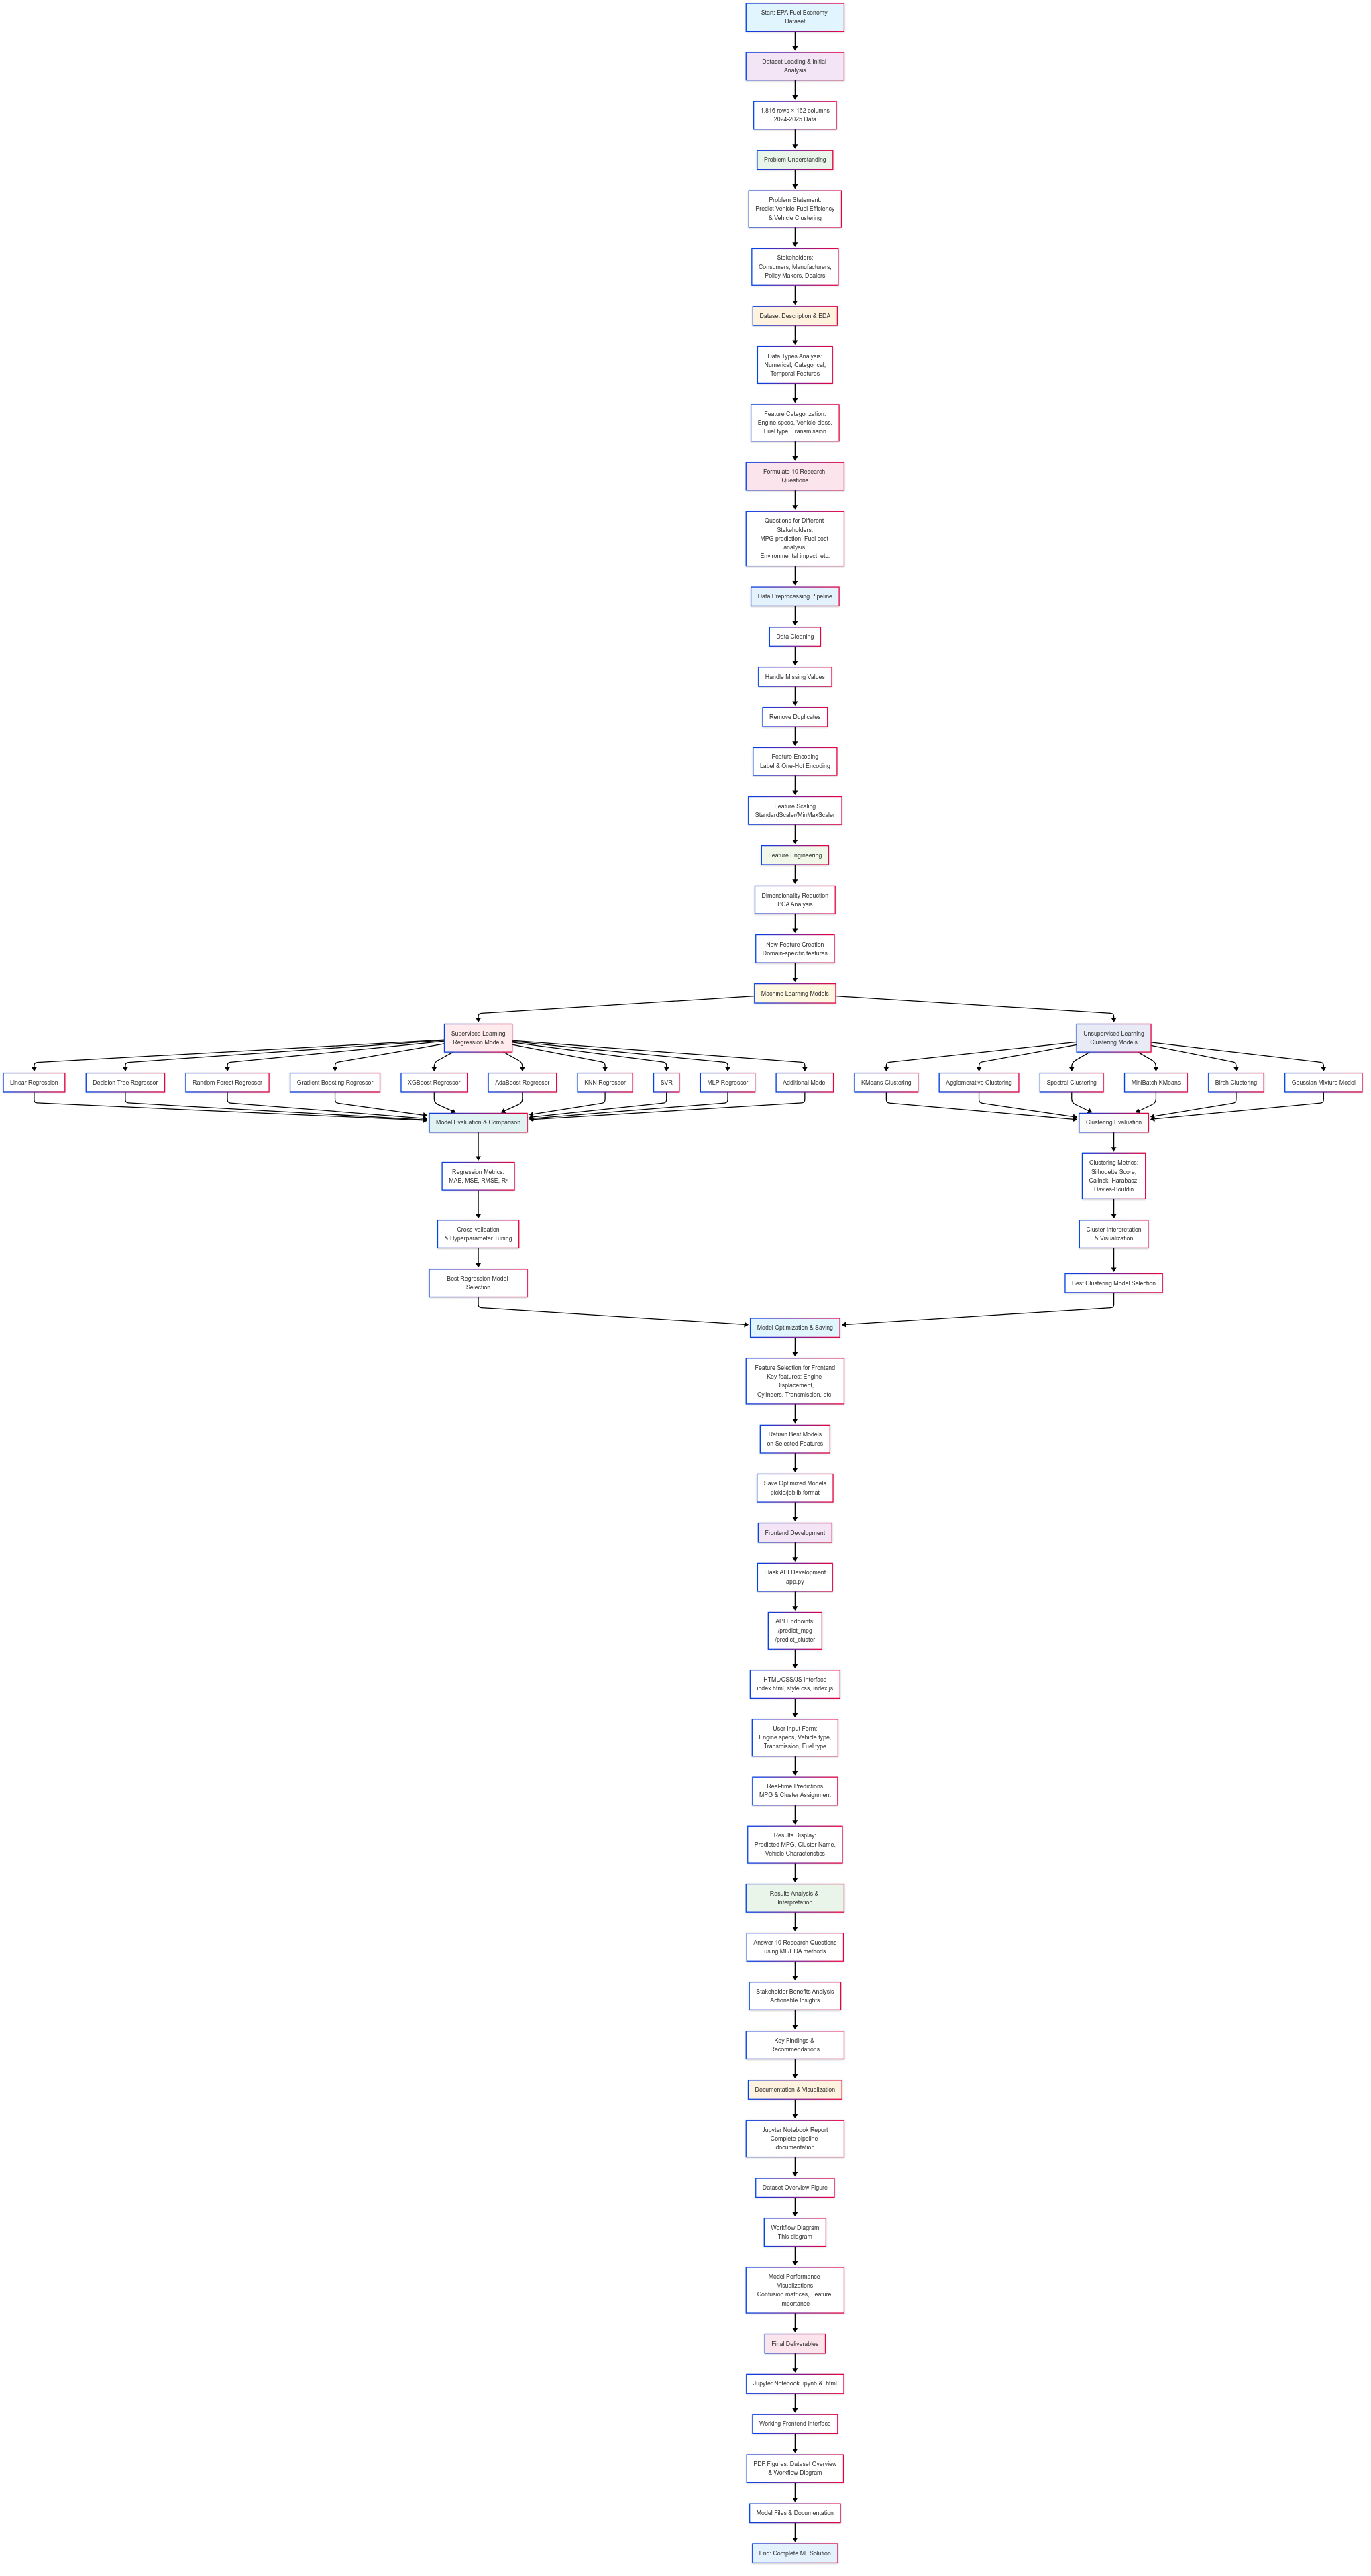

In [64]:
from IPython.display import Image

Image("workflow.png")

## Testing

## What Is a Good City MPG?

MPG (Miles Per Gallon) indicates how far a vehicle can travel using one gallon of fuel. Higher MPG means better fuel efficiency, especially for city driving where stop-and-go traffic is common.

---

### **City MPG Benchmarks by Vehicle Type**

| Vehicle Type            | Typical City MPG | Notes |
|--------------------------|------------------|-------|
| **Compact Cars**         | 25–35+            | Efficient city driving (e.g., Honda Civic) |
| **Hybrids**              | 40–60+            | Extremely efficient (e.g., Toyota Prius) |
| **Midsize Sedans**       | 20–30             | Balanced performance and comfort |
| **SUVs / Crossovers**    | 15–25             | Less efficient due to size and weight |
| **Pickup Trucks**        | 12–20             | Lowest MPG due to large engines and payload |

---

### **General MPG Ratings (City Driving)**

| Rating     | City MPG Range | Interpretation                          |
|------------|----------------|-----------------------------------------|
| Excellent  | 35 and above   | Hybrid or very efficient compact car    |
| Good       | 25–34          | Typical for small-to-mid-sized vehicles |
| Average    | 18–24          | Moderate efficiency                     |
| Poor       | Below 18       | Inefficient, often large SUVs or trucks |

---

### Notes for Users:
- Fuel efficiency can vary significantly depending on driving habits, road conditions, and maintenance.
- Electric vehicles (EVs) use a different measure: **MPGe** (Miles Per Gallon Equivalent), typically 90–120+ MPGe for city.

---

> **Example**:  
> A predicted city MPG of **28.5** is considered **👍 Good**, especially for a midsize sedan.  
> If the value is **35+**, it qualifies as **🚀 Excellent**, typical for hybrids and compact vehicles.


In [65]:
for col in X.columns:
    print(col)


Model Year
Eng Displ
# Cyl
# Gears
Hwy FE (Guide) - Conventional Fuel
Comb FE (Guide) - Conventional Fuel
Annual Fuel1 Cost - Conventional Fuel
Carline Class
Max Ethanol % - Gasoline
2Dr Pass Vol
2Dr Lugg Vol
4Dr Pass Vol
4Dr Lugg Vol
Htchbk Pass Vol
Htchbk Lugg Vol
Intake Valves Per Cyl
Exhaust Valves Per Cyl
SmartWay1 (EPA-derived SmartWay rating for Test Group 1)
GHG Rating (1-10 rating on Label)
City CO2 Rounded Adjusted
Comb CO2 Rounded Adjusted (as shown on FE Label)
engine_efficiency
total_pass_vol
smartway_binary
Transmission_Auto(A6)
Transmission_Auto(A8)
Transmission_Auto(A9)
Transmission_Auto(AM-S6)
Transmission_Auto(AM-S7)
Transmission_Auto(AM-S8)
Transmission_Auto(AM7)
Transmission_Auto(AM8)
Transmission_Auto(AV)
Transmission_Auto(AV-S1)
Transmission_Auto(AV-S10)
Transmission_Auto(AV-S6)
Transmission_Auto(AV-S7)
Transmission_Auto(AV-S8)
Transmission_Auto(S10)
Transmission_Auto(S5)
Transmission_Auto(S6)
Transmission_Auto(S7)
Transmission_Auto(S8)
Transmission_Auto(S9)
Trans

#### Regression Testing

In [66]:
# Load the saved model
model = joblib.load("models/XGBoost.pkl")
print(X.iloc[100])  # Display a sample row for prediction

sample = X.iloc[[50]]  # Use any valid row index

prediction = best_model.predict(sample)
print("Predicted City MPG:", prediction[0])


Model Year                                                    2025
Eng Displ                                                      2.0
# Cyl                                                            4
# Gears                                                          8
Hwy FE (Guide) - Conventional Fuel                              31
                                                             ...  
Var Valve Lift?_Y                                            False
Cyl Deact?_Unknown                                           False
Cyl Deact?_Y                                                 False
Stop/Start System (Engine Management System) Code_Unknown    False
Stop/Start System (Engine Management System) Code_Y          False
Name: 100, Length: 77, dtype: object
Predicted City MPG: 17.002056


#### Clustering Testing

In [67]:
# Load model and preprocessing tools
clustering_model = joblib.load("models/Birch.pkl")
scaler = joblib.load("models/scaler.pkl")
expected_cols = joblib.load("models/model_columns.pkl")  # Full column list

# Handle missing values in df (full dataset)
df_cleaned = df.fillna(df.median(numeric_only=True)).fillna(
    "Unknown"
)  # Ensures no NaNs

# Sample row for test
sample_input = df_cleaned.iloc[[2]]  # Use a valid row index

# One-hot encode the row and align with training columns
sample_encoded = pd.get_dummies(sample_input)
for col in expected_cols:
    if col not in sample_encoded.columns:
        sample_encoded[col] = 0
sample_encoded = sample_encoded[expected_cols]

# Scale
sample_scaled = scaler.transform(sample_encoded)

# Predict cluster
cluster = clustering_model.predict(sample_scaled)[0]
print("Assigned Cluster:", cluster)

# Predict for the full dataset
df_encoded_full = pd.get_dummies(df_cleaned).reindex(
    columns=expected_cols, fill_value=0
)
df_scaled_full = scaler.transform(df_encoded_full)
df["cluster"] = clustering_model.predict(df_scaled_full)

# View stats for that cluster
df[df["cluster"] == cluster].describe()


Assigned Cluster: 0


,Model Year,Eng Displ,# Cyl,# Gears,city_mpg,Hwy FE (Guide) - Conventional Fuel,Comb FE (Guide) - Conventional Fuel,Annual Fuel1 Cost - Conventional Fuel,Carline Class,Max Ethanol % - Gasoline,...,Intake Valves Per Cyl,Exhaust Valves Per Cyl,SmartWay1 (EPA-derived SmartWay rating for Test Group 1),GHG Rating (1-10 rating on Label),City CO2 Rounded Adjusted,Comb CO2 Rounded Adjusted (as shown on FE Label),engine_efficiency,total_pass_vol,smartway_binary,cluster
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,278.000000,0.0,278.000000,278.000000,278.000000,278.000000,278.000000,278.0,278.0
mean,2024.406475,2.740647,5.104317,6.953237,20.165468,27.449640,22.917266,2834.532374,9.017986,14.460432,...,1.996403,1.996403,NaN,4.895683,443.820144,394.911871,1.901037,267.989209,0.0,0.0
std,0.492061,0.979263,1.673724,0.765672,4.280924,5.655193,4.745926,696.195150,11.534114,13.854461,...,0.059976,0.059976,NaN,0.550598,53.642721,46.415720,0.240162,6.424504,0.0,0.0
min,2024.000000,1.500000,3.000000,5.000000,8.000000,11.000000,9.000000,1550.000000,1.000000,10.000000,...,1.000000,1.000000,NaN,3.000000,311.000000,273.000000,1.290323,247.000000,0.0,0.0
25%,2024.000000,2.000000,4.000000,6.000000,17.000000,23.000000,19.000000,2350.000000,2.000000,10.000000,...,2.000000,2.000000,NaN,5.000000,444.000000,397.500000,1.666667,262.000000,0.0,0.0
50%,2024.000000,2.500000,4.000000,7.000000,19.500000,27.000000,22.000000,2750.000000,3.500000,10.000000,...,2.000000,2.000000,NaN,5.000000,444.000000,397.500000,2.000000,271.000000,0.0,0.0
75%,2025.000000,3.000000,6.000000,8.000000,23.000000,32.000000,26.000000,3200.000000,6.000000,15.000000,...,2.000000,2.000000,NaN,5.000000,444.000000,397.500000,2.000000,271.000000,0.0,0.0
max,2025.000000,8.000000,16.000000,9.000000,29.000000,42.000000,34.000000,7150.000000,33.000000,85.000000,...,2.000000,2.000000,NaN,6.000000,638.000000,556.000000,2.666667,292.000000,0.0,0.0


### Frontend Models (Simplified training)

Reducing the number of columns by only using key features so that user does not have to enter a lot of details/one hot encoding doesn't encode almost everything as 0 (Unknown)

#### Regression

In [68]:
# Define key features
key_features = [
    "Eng Displ",
    "# Cyl",
    "Transmission",
    "Drive Sys",
    "Carline Class",
    "smartway_binary",
    "Fuel Usage  - Conventional Fuel",
]

# Prepare data
X_simple = df[key_features]
y_simple = df["city_mpg"]

# Encode
X_simple_encoded = pd.get_dummies(X_simple)
key_columns = list(X_simple_encoded.columns)
joblib.dump(key_columns, "models/key_columns.pkl")

# Scale
scaler_simple = StandardScaler()
X_simple_scaled = scaler_simple.fit_transform(X_simple_encoded)
joblib.dump(scaler_simple, "models/simplified_scaler.pkl")

# Train/test split
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple_scaled, y_simple, test_size=0.3, random_state=42
)

# Train model
xgb_simple = XGBRegressor(random_state=42)
xgb_simple.fit(X_train_simple, y_train_simple)

# Save
joblib.dump(xgb_simple, "models/XGBoost_simple.pkl")


['models/XGBoost_simple.pkl']

#### Clustering

In [69]:
from collections import Counter

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_simple_scaled)

clusters = kmeans.predict(X_simple_scaled)
print("KMeans cluster distribution:", Counter(clusters))

joblib.dump(kmeans, "models/KMeans_simple.pkl")

KMeans cluster distribution: Counter({np.int32(2): 1337, np.int32(0): 372, np.int32(1): 107})


['models/KMeans_simple.pkl']